# Import libraries

In [1]:
from cpymad.madx import Madx
from cpymad.madx import Table
import numpy as np
import sys
import matplotlib.pyplot as plt 
import os

import pandas as pd
import scipy as sp
import scipy.stats as spstats
import scipy.optimize as spopt

import tfs

In [2]:
%run ./DefiningMachineParameters.ipynb

# Define a few beam parameters

In [3]:
BeamMomentum_val = 3.574
Beam_H_size_val, Beam_V_size_val = 1.0E-6, 1.0E-6
EnergySpread_val = 0
NumberParticles_val = 3e7

In [4]:
BRHO_value, BeamMomentum = MagneticRigidity (BeamMomentum_val)
print(BRHO_value, "Tm --> which corresponds to p = ", BeamMomentum, 
      "GeV/c, which is the approximation of", BRHO_value*2.998e8/1e9)

11.9214344 Tm --> which corresponds to p =  3.574 GeV/c, which is the approximation of 3.5740460331200006


## Define Nominal strenghts quadrupoles

In [54]:
Strength = StrenghtsQuadrupoles (ChoiceOptics = "FromPavel", TrimsStauts = "OFF", BeamMomentum = BeamMomentum_val)
print(Strength)

Strenght = StrenghtsQuadrupoles (ChoiceOptics = "FromCurrents", TrimsStauts = "OFF", BeamMomentum = BeamMomentum_val)
print(Strenght)

[0.558153759866, -0.558153759866, 0.594999986705, -0.36175160802, 0.5138363513326396, -0.4632118053127934, -0.4632118053127934, 0.5138363513326396, 0.434013207981, 0.560993621836, -0.41302779456860844, -0.526485397793]
[0.5332202500000001, -0.5625466389509763, 0.5911970816850723, -0.3338895651461145, 0.5625466388306114, -0.479536179, -0.4737907008510111, 0.5441015835547189, 0.4472595247614086, 0.5679667841488978, -0.4185343875259151, -0.5416327368837879]


# Define nominal strenghts dipoles

In [55]:
TrimsDipoles =  DipoleTrims (BeamMomentum = BeamMomentum_val, AdjustTrims=False)

# Run a TWISS

In [56]:
# # Performing a Twiss
def TwissFunction (DoIWantATwiss, IsItAPTCTwiss, BeamMomentum, BRHO_VALUE, BeamEnergy, Beam_H_size, Beam_V_size, EnergySpread, 
                   NumberParticles, ValkQFNS, ValkQDS, ValkQFNECool, ValkQDNEcool, ValkQFN, ValkQDN, ValkQDC53, 
                   ValkQFC54,ValkQFW6, ValkQFW8, ValkQDW7, ValkQDW9, KBHZTRIM,KBHZTR0506,KBHZTR0809,KBHZTR1112,
                   KBHZTR1718,KBHZTR2021,KBHZTR2324,KBHZTR3334,KBHZTR3637,KBHZTR3940,KBHZTR4546,KBHZTR4849, KBHZTR5152):
    if DoIWantATwiss == True:
        madx = mad_setup(BeamMomentum, BRHO_VALUE, BeamEnergy, Beam_H_size, Beam_V_size, EnergySpread, NumberParticles, ValkQFNS, ValkQDS, 
                         ValkQFNECool, ValkQDNEcool, ValkQFN, ValkQDN, ValkQDC53, ValkQFC54, ValkQFW6, ValkQFW8, 
                         ValkQDW7, ValkQDW9,KBHZTRIM,KBHZTR0506,KBHZTR0809,KBHZTR1112,KBHZTR1718,KBHZTR2021,KBHZTR2324,
                         KBHZTR3334,KBHZTR3637,KBHZTR3940,KBHZTR4546,KBHZTR4849, KBHZTR5152)
        
        if IsItAPTCTwiss == False:
            s = '''
            Select, flag=twiss, clear;
            Select, flag=twiss, column=name,s,betx,alfx,mux,bety,alfy,muy, dx, dy, L, apertype,aper_1,aper_2, aper_3, aper_4;
            twiss, DELTAP = 0, FILE = twiss.txt;

            Select, flag=aperture, column=apertype, aper_1, aper_2, aper_3, aper_4;   
            APERTURE, range = #s/#e, file = apertures_AD.txt;
            '''
            madx.input(s)
            results_in_table = Table.dframe(madx.table['twiss']).reset_index(drop=True)

        else:
            s = '''
            ptc_create_universe;
            ptc_create_layout, time=false, model=2, exact=true, method=6, nst=5;
            ptc_twiss, closed_orbit, icase=56, no=4, slice_magnets;
            ptc_end;
            '''
            madx.input(s)
            results_in_table = Table.dframe(madx.table['ptc_twiss']).reset_index(drop=True)
    else:
        print(" You didn't want to make a TWISS! ")
        results_in_table = pd.DataFrame()
    
    madx.quit()
    return results_in_table

In [57]:
TwissADLattice = TwissFunction(DoIWantATwiss = 1, IsItAPTCTwiss = False, BeamMomentum = BeamMomentum_val,  
                               BRHO_VALUE =BRHO_value,
                               BeamEnergy=MagneticRigidity(1)[1], Beam_H_size=Beam_H_size_val, 
                               Beam_V_size=Beam_V_size_val, EnergySpread=EnergySpread_val, 
                               NumberParticles=NumberParticles_val, 
                               ValkQFNS = Strenght[0],
                               ValkQDS = Strenght[1], ValkQFNECool = Strenght[2], 
                               ValkQDNEcool = Strenght[3], ValkQFN = Strenght[4],
                               ValkQDN = Strenght[5], ValkQDC53 = Strenght[6], 
                               ValkQFC54 = Strenght[7], ValkQFW6 = Strenght[8], 
                               ValkQFW8 = Strenght[9], ValkQDW9 = Strenght[10],
                               ValkQDW7 = Strenght[11], 
                               KBHZTRIM = TrimsDipoles[0],
                               KBHZTR0506 = TrimsDipoles[1], KBHZTR0809 = TrimsDipoles[2], KBHZTR1112 = TrimsDipoles[3], 
                               KBHZTR1718 = TrimsDipoles[4], KBHZTR2021 = TrimsDipoles[5], KBHZTR2324 = TrimsDipoles[6], 
                               KBHZTR3334 = TrimsDipoles[7], KBHZTR3637 = TrimsDipoles[8], KBHZTR3940 = TrimsDipoles[9],
                               KBHZTR4546 = TrimsDipoles[10], KBHZTR4849 = TrimsDipoles[11], KBHZTR5152 = TrimsDipoles[12])

3.574

  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2023.11.17 11:27:41      +
  ++++++++++++++++++++++++++++++++++++++++++++
/* *************************************************************

 * Official sequence of AD based on previous files.

 * It first defines each element type by type

 * 

 ************************************************************* */



! Imported with minor modifications from Pavel:

!

! - removed call of /afs/cern.ch/user/b/beloshit/public/ad/madx/AD_markers_imitating_quad:

!    -> This file creates new elements: QDN13.E:SBEND and QDN13.S:MARKER which are not used anywere.

! - merged with /afs/cern.ch/user/b/beloshit/public/ad/madx/AD_PUs

!    -> This file contains the monitors definition. It has to be called from "master" madx file

! - corrected a typo in RFCAVITY for bunch rotation definiti


++++++ table: summ

            length             orbit5               alfa            gammatr 
          182.4328                 -0       0.0415549239        4.905561835 

                q1                dq1            betxmax              dxmax 
       5.625511242       -20.67678908        16.96243468        13.30435739 

             dxrms             xcomax             xcorms                 q2 
       6.008701819      0.02133631583     0.008212397138        5.329268639 

               dq2            betymax              dymax              dyrms 
      -22.24730672        23.19502928    2.311655798e-17    9.602417721e-18 

            ycomax             ycorms             deltap            synch_1 
   4.781245132e-19    1.721056572e-19                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

           synch_6            synch_8            

# plot aperture

(-150.0, 150.0)

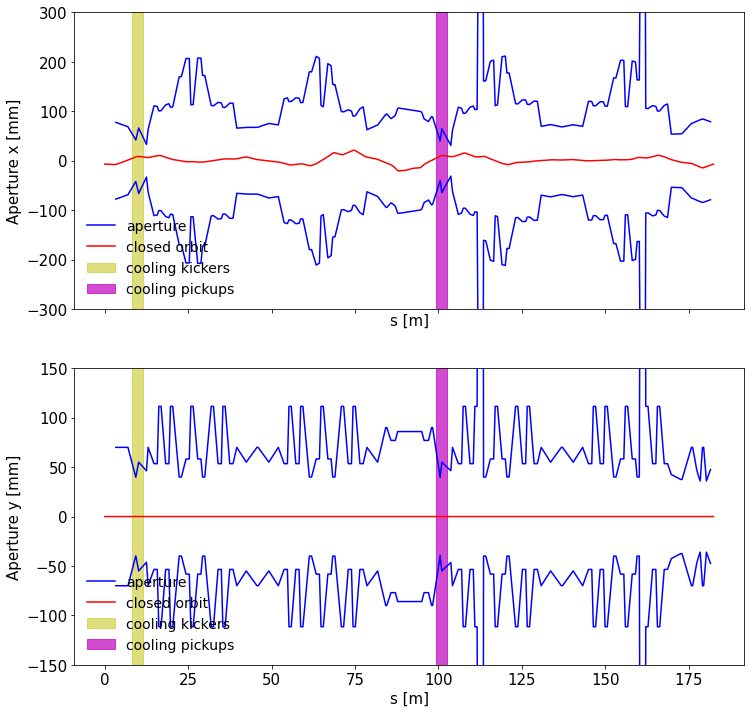

In [58]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12), sharex = True, sharey = False)

ax1.plot(TwissADLattice[TwissADLattice["aper_1"]>0]["s"], TwissADLattice[TwissADLattice["aper_1"]>0]["aper_1"]*1e3-TwissADLattice[TwissADLattice["aper_1"]>0]["x"]*1e3, "-b")
ax1.plot(TwissADLattice[TwissADLattice["aper_1"]>0]["s"], -TwissADLattice[TwissADLattice["aper_1"]>0]["aper_1"]*1e3+TwissADLattice[TwissADLattice["aper_1"]>0]["x"]*1e3, "-b", label = "aperture")

ax1.plot(TwissADLattice["s"], TwissADLattice["x"]*1e3, "-r", label = "closed orbit")

ax1.axvspan(xmin = 7.097500 + 1.1, xmax = 10.297500 + 1.1, ymin=0 , ymax=25, alpha=0.5, color="y", label = "cooling kickers")
ax1.axvspan(xmin = 98.316400 + 1.1, xmax = 101.513900 + 1.1, ymin=0 , ymax=25, alpha=0.7, color="m", label = "cooling pickups")

ax1.set_xlabel("s [m]", size = 15)
ax1.set_ylabel("Aperture x [mm]", size = 15)
ax1.legend(frameon = False, prop = {"size":14}, loc = 3)
ax1.set_ylim([-300, 300])
# ax1.set_xlim([10, 15])
ax1.tick_params(axis = "both", which = "major", labelsize = 15)


ax2.plot(TwissADLattice[TwissADLattice["aper_2"]>0]["s"], TwissADLattice[TwissADLattice["aper_2"]>0]["aper_2"]*1e3, "-b")
ax2.plot(TwissADLattice[TwissADLattice["aper_2"]>0]["s"], -TwissADLattice[TwissADLattice["aper_2"]>0]["aper_2"]*1e3, "-b", label = "aperture")

ax2.plot(TwissADLattice["s"], TwissADLattice["y"]*1e3, "-r", label = "closed orbit")

ax2.axvspan(xmin = 7.097500 + 1.1, xmax = 10.297500 + 1.1, ymin=0 , ymax=25, alpha=0.5, color="y", label = "cooling kickers")
ax2.axvspan(xmin = 98.316400 + 1.1, xmax = 101.513900 + 1.1, ymin=0 , ymax=25, alpha=0.7, color="m", label = "cooling pickups")

ax2.set_xlabel("s [m]", size = 15)
ax2.set_ylabel("Aperture y [mm]", size = 15)
ax2.tick_params(axis = "both", which = "major", labelsize = 15)
ax2.legend(frameon = False, prop = {"size":14}, loc = 3)
ax2.set_ylim([-150, 150])

# plot acceptance

H 212.75901919243987
H 288.2942839855939
V 173.9052046038578


(0.0, 800.0)

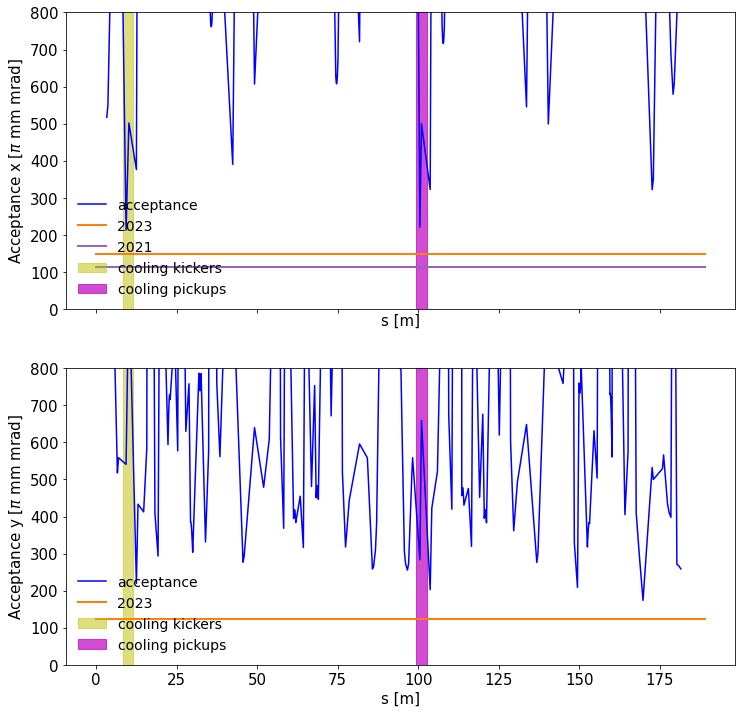

In [59]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12), sharex = True, sharey = False)

ax1.plot(TwissADLattice[TwissADLattice["aper_1"]>0]["s"], 
         (TwissADLattice[TwissADLattice["aper_1"]>0]["aper_1"]*1e3-TwissADLattice[TwissADLattice["aper_1"]>0]["x"]*1e3)**2/TwissADLattice[TwissADLattice["aper_1"]>0]["betx"], "-b")
ax1.plot(TwissADLattice[TwissADLattice["aper_1"]>0]["s"], 
         -(TwissADLattice[TwissADLattice["aper_1"]>0]["aper_1"]*1e3-TwissADLattice[TwissADLattice["aper_1"]>0]["x"]*1e3)**2/TwissADLattice[TwissADLattice["aper_1"]>0]["betx"], "-b", label = "acceptance")

print("H", min((TwissADLattice[TwissADLattice["aper_1"]>0]["aper_1"]*1e3-TwissADLattice[TwissADLattice["aper_1"]>0]["x"]*1e3)**2/TwissADLattice[TwissADLattice["aper_1"]>0]["betx"]))
print("H", min((TwissADLattice[TwissADLattice["aper_1"]>0]["aper_1"]*1e3)**2/TwissADLattice[TwissADLattice["aper_1"]>0]["betx"]))

ax1.plot( [0, 189],  [148.4905439563445, 148.4905439563445] , "-", lw = 2,  color="tab:orange", label = "2023")
ax1.plot( [0, 189],  [113, 113] , "-", lw = 2, color="tab:purple", label = "2021")

ax1.axvspan(xmin = 7.097500 + 1.1, xmax = 10.297500 + 1.1, ymin=0 , ymax=25, alpha=0.5, color="y", label = "cooling kickers")
ax1.axvspan(xmin = 98.316400 + 1.1, xmax = 101.513900 + 1.1, ymin=0 , ymax=25, alpha=0.7, color="m", label = "cooling pickups")

ax1.set_xlabel("s [m]", size = 15)
ax1.set_ylabel(r"Acceptance x [$\pi$ mm mrad]", size = 15)
ax1.legend(frameon = False, prop = {"size":14}, loc = 3)
ax1.set_ylim([0, 800])
# ax1.set_xlim([10, 15])
ax1.tick_params(axis = "both", which = "major", labelsize = 15)


ax2.plot(TwissADLattice[TwissADLattice["aper_2"]>0]["s"], (TwissADLattice[TwissADLattice["aper_2"]>0]["aper_2"]*1e3)**2/TwissADLattice[TwissADLattice["aper_2"]>0]["bety"], "-b")
ax2.plot(TwissADLattice[TwissADLattice["aper_2"]>0]["s"], -(TwissADLattice[TwissADLattice["aper_2"]>0]["aper_2"]*1e3)**2/TwissADLattice[TwissADLattice["aper_2"]>0]["bety"], "-b", label = "acceptance")

ax2.plot( [0, 189], [ 123.19980792802347, 123.19980792802347], "-", lw = 2,   color="tab:orange", label = "2023")

print("V", min((TwissADLattice[TwissADLattice["aper_2"]>0]["aper_2"]*1e3)**2/TwissADLattice[TwissADLattice["aper_2"]>0]["bety"]))

# ax2.axvspan(xmin = 85.776800, xmax = 96.656000, ymin=0 , ymax=25, alpha=0.5, color="y", label = "e-cooler")
ax2.axvspan(xmin = 7.097500 + 1.1, xmax = 10.297500 + 1.1, ymin=0 , ymax=25, alpha=0.5, color="y", label = "cooling kickers")
ax2.axvspan(xmin = 98.316400 + 1.1, xmax = 101.513900 + 1.1, ymin=0 , ymax=25, alpha=0.7, color="m", label = "cooling pickups")

ax2.set_xlabel("s [m]", size = 15)
ax2.set_ylabel(r"Acceptance y [$\pi$ mm mrad]", size = 15)
ax2.tick_params(axis = "both", which = "major", labelsize = 15)
ax2.legend(frameon = False, prop = {"size":14}, loc = 3)
ax2.set_ylim([0, 800])

In [60]:
TwissADLattice_Currents = TwissADLattice

In [52]:
TwissADLattice_Pavel = TwissADLattice

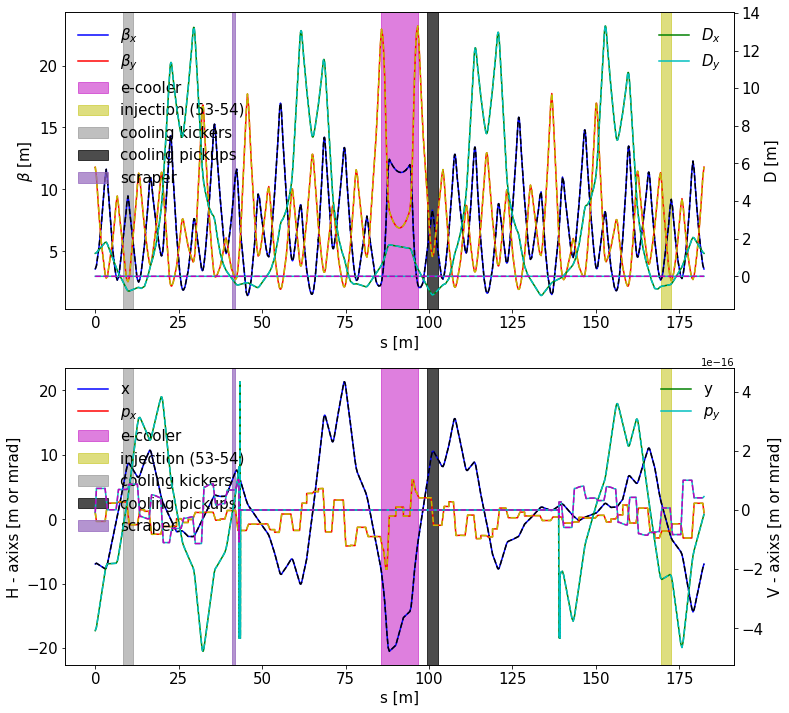

In [63]:
f, (ax1, ax2) = plt.subplots(2,1, figsize = (12,12))

#ax1
ax1.plot(TwissADLattice_Pavel.s, TwissADLattice_Pavel.betx, "b", label = r"$\beta_x$")
ax1.plot(TwissADLattice_Currents.s, TwissADLattice_Currents.betx, "--k")
ax1.plot(TwissADLattice_Pavel.s, TwissADLattice_Pavel.bety, "r", label = r"$\beta_y$")
ax1.plot(TwissADLattice_Currents.s, TwissADLattice_Currents.bety, "--y")
ax1.axvspan(xmin = 85.776800, xmax = 96.656000, ymin=0 , ymax=25, alpha=0.5, color="m", label = "e-cooler")
ax1.axvspan(xmin = 169.432800, xmax = 172.632800, ymin=0 , ymax=25, alpha=0.5, color="y", label = "injection (53-54)")
ax1.axvspan(xmin = 7.097500 + 1.1, xmax = 10.297500 + 1.1, ymin=0 , ymax=25, alpha=0.5, color="grey", label = "cooling kickers")
ax1.axvspan(xmin = 98.316400 + 1.1, xmax = 101.513900 + 1.1, ymin=0 , ymax=25, alpha=0.7, color="k", label = "cooling pickups")
ax1.axvspan(xmin = 40.85420, xmax = 40.85420 + 1.1, ymin=0 , ymax=25, alpha=0.7, color="tab:purple", label = "scraper")

ax1_bis = ax1.twinx()
ax1_bis.plot(TwissADLattice_Pavel.s, TwissADLattice_Pavel.dx, "g", label = r"$D_x$")
ax1_bis.plot(TwissADLattice_Currents.s, TwissADLattice_Currents.dx, "--c")
ax1_bis.plot(TwissADLattice_Pavel.s, TwissADLattice_Pavel.dy, "c", label = r"$D_y$")
ax1_bis.plot(TwissADLattice_Currents.s, TwissADLattice_Currents.dy, "--m")
#ax1 axis setting
ax1.set_xlabel("s [m]", size = 15)
ax1.set_ylabel(r"$\beta$ [m]", size = 15)
ax1.tick_params(axis = "both", which = "major", labelsize = 15)
ax1.legend(prop = {"size": 15}, frameon = False, loc = 2)

ax1_bis.set_ylabel("D [m]", size = 15)
ax1_bis.tick_params(axis = "both", which = "major", labelsize = 15)
ax1_bis.legend(prop = {"size": 15}, frameon = False)



#ax2

ax2.plot(TwissADLattice_Pavel.s, TwissADLattice_Pavel.x*1e3, "b", label = "x")
ax2.plot(TwissADLattice_Currents.s, TwissADLattice_Currents.x*1e3, "--k")
ax2.plot(TwissADLattice_Pavel.s, TwissADLattice_Pavel.px*1e3, "r", label = "$p_x$")
ax2.plot(TwissADLattice_Currents.s, TwissADLattice_Currents.px*1e3, "--y")
ax2.axvspan(xmin = 85.776800, xmax = 96.656000, ymin=0 , ymax=25, alpha=0.5, color="m", label = "e-cooler")
ax2.axvspan(xmin = 169.432800, xmax = 172.632800, ymin=0 , ymax=25, alpha=0.5, color="y", label = "injection (53-54)")
ax2.axvspan(xmin = 7.097500 + 1.1, xmax = 10.297500 + 1.1, ymin=0 , ymax=25, alpha=0.5, color="grey", label = "cooling kickers")
ax2.axvspan(xmin = 98.316400 + 1.1, xmax = 101.513900 + 1.1, ymin=0 , ymax=25, alpha=0.7, color="k", label = "cooling pickups")
ax2.axvspan(xmin = 40.85420, xmax = 40.85420 + 1.1, ymin=0 , ymax=25, alpha=0.7, color="tab:purple", label = "scraper")

ax2_bis = ax2.twinx()
ax2_bis.plot(TwissADLattice_Pavel.s, TwissADLattice_Pavel.y*1e3, "g", label = "y")
ax2_bis.plot(TwissADLattice_Currents.s, TwissADLattice_Currents.y*1e3, "--c")
ax2_bis.plot(TwissADLattice_Pavel.s, TwissADLattice_Pavel.py*1e3, "c", label = "$p_y$")
ax2_bis.plot(TwissADLattice_Currents.s, TwissADLattice_Currents.py*1e3, "--m")

#ax2 axis setting
ax2.set_xlabel("s [m]", size = 15)
ax2.set_ylabel("H - axixs [m or mrad]", size = 15)
ax2.tick_params(axis = "both", which = "major", labelsize = 15)
ax2.legend(prop = {"size": 15}, frameon = False, loc = 2)

ax2_bis.set_ylabel("V - axixs [m or mrad]", size = 15)
ax2_bis.tick_params(axis = "both", which = "major", labelsize = 15)
ax2_bis.legend(prop = {"size": 15}, frameon = False, loc = 1)

# f.savefig("./highenergy/Nominal_AD_Optics_Plots.pdf")